# VOC Processing Data

## Code for processing availible data on Github

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import StringIO

### Sample Metadata

In [30]:
# ----------------------------------------------------------------------------------------------------#
# - Bring in public data -
# ----------------------------------------------------------------------------------------------------#

# Try and access file path of public data 
url = 'https://github.com/cshuler/VOC_Processing_Maui/blob/main/MASTER_Maui_VOC_Sheet_PUBLIC.csv?raw=true'
all_df = pd.read_csv(url,index_col=0)
print(all_df.head(5))

     Sample ID          SampleType   DateTime Taken Post Results    Public X  \
0  08-16-CKS-1           DI water    8/16/2023 8:15            N -156.475003   
1  08-16-CKS-2           Tap Water   8/16/2023 9:30          NaN -156.311886   
2  08-16-CKS-3           Tap Water  8/16/2023 10:52          NaN -156.309926   
3  08-16-CKS-4           Tap Water  8/16/2023 11:11          NaN -156.307487   
4  08-16-CKS-5  Tap Water Filtered  8/16/2023 11:30          NaN -156.308135   

    Public Y  
0  20.891460  
1  20.778782  
2  20.779907  
3  20.775916  
4  20.778905  


### VOC data

In [31]:
# ----------------------------------------------------------------------------------------------------#
# - Bring in clean VOC data -
# ----------------------------------------------------------------------------------------------------#

#Function to get the list of CSV files from the GitHub repository page
def get_csv_files_from_repo(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        files = response.json()
        csv_files = [file['download_url'] for file in files if file['name'].endswith('.csv')]
        return csv_files
    else:
        raise ValueError(f"Failed to fetch repository contents: {response.status_code}")

#URL of the GitHub repository API
api_url = "https://api.github.com/repos/cshuler/VOC_Processing_Maui/contents/Clean_Data"

# Get the list of CSV files
csv_files = get_csv_files_from_repo(api_url)
csv_files
# Check if the list of CSV files is populated
if not csv_files:
    raise ValueError("No CSV files found in the repository")

# Function to read a CSV file from a URL into a DataFrame
def read_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for bad status codes
    return pd.read_csv(StringIO(response.text))

# Read all CSV files into a list of DataFrames and set 'Peak' as the index
dataframes = []
for url in csv_files:
    try:
        df = read_csv_from_url(url)
        df.set_index('Peak', inplace=True)
        dataframes.append(df)
    except Exception as e:
        print(f"Error reading {url}: {e}")
# Ensure there are DataFrames to concatenate
if not dataframes:
    raise ValueError("No DataFrames were read successfully")

In [32]:
# ----------------------------------------------------------------------------------------------------#
# - Calc detects -
# ----------------------------------------------------------------------------------------------------#

def compare_samples_to_limit(df):
    # Identify the reporting limit column
    limit_col = [col for col in df.columns if 'Reporting_Limit' in col][0]
    
    # Identify the sample columns (all columns except the reporting limit)
    sample_cols = [col for col in df.columns if col != limit_col]
    
    # Compare and set sample values
    for sample_col in sample_cols:
        df[sample_col] = df.apply(lambda row: np.nan if row[sample_col] < row[limit_col] else row[sample_col], axis=1)
    
    return df

# Process each DataFrame
for i, df in enumerate(dataframes):
    df.replace(['n.a.', 'n.a./n.r.'], np.nan, inplace=True)
    # Convert all values to numeric (float), coercing errors to NaN
    df = df.apply(pd.to_numeric, errors='coerce')
    dataframes[i] = compare_samples_to_limit(df) 
df.head(5)
#ALL VALUES LESS THAN REPORTING LIMIT IS SET TO NAN#

,Reporting_Limit,10-04-24-KDP-01,10-04-24-KDP-02,10-04-24-KDP-03,10-04-24-KDP-04,10-04-24-KDP-05,10-04-24-KDP-06,10-04-24-KDP-07,10-04-24-KDP-08,10-04-24-KDP-09,10-04-24-KDP-10
Peak,,,,,,,,,,,
Chloromethane (methyl chloride),1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chloroethene (vinyl chloride),1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bromomethane (methyl bromide),1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chloroethane (ethyl chloride),1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Trichlorofluoromethane,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Combine Datasets

In [33]:
# ----------------------------------------------------------------------------------------------------#
# - Combine both datasets -
# ----------------------------------------------------------------------------------------------------#

# Combine all DataFrames into one using an outer join to align the chemicals
combined_df = pd.concat(dataframes, axis=1, join='outer')

# Display the combined DataFrame
print("Combined DataFrame:")
combined_df.head()

Combined DataFrame:


,Reporting_Limit,HolmesTap,08-16-CKS-1,08-16-CKS-2,08-16-CKS-7,08-16-CKS-8,08-16-CKS-10,08-16-CKS-12,Reporting_Limit,DIH2O-Vial,...,10-04-24-KDP-01,10-04-24-KDP-02,10-04-24-KDP-03,10-04-24-KDP-04,10-04-24-KDP-05,10-04-24-KDP-06,10-04-24-KDP-07,10-04-24-KDP-08,10-04-24-KDP-09,10-04-24-KDP-10
Peak,,,,,,,,,,,,,,,,,,,,,
Chloromethane (methyl chloride),2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chloroethene (vinyl chloride),2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bromomethane (methyl bromide),2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chloroethane (ethyl chloride),2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Trichlorofluoromethane,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
#Define chemical list

specified_chemicals = ["Chloromethane (methyl chloride)", "Chloroethene (vinyl chloride)", 
    "Bromomethane (methyl bromide)", "Chloroethane (ethyl chloride)",
    "Trichlorofluoromethane", "Diethyl ether", "1,1-Dichloroethene", "Acetone",
    "Iodomethane", "Carbon disulfide", "3-Chloropropene (allyl chloride)",
    "Methylene chloride (DCM)", "trans-1,2-Dichloroethene", "Methyl tert-butyl ether (MTBE)",
    "1,1-Dichloroethane", "2,2-Dichloropropane", "cis-1,2-Dichloroethene", "2-Butanone (MEK)",
    "Methyl acrylate", "Methacrylonitrile", "Bromochloromethane", "Tetrahydrofuran",
    "Trichloromethane (chloroform)", "1,1,1-Trichloroethane", "1-Chlorobutane (butyl chloride)", "Carbon tetrachloride",
    "1,1-Dichloropropene", "Benzene", "1,2-Dichloroethane",
    "Trichloroethene", "1,2-Dichloropropane", "Dibromomethane", "Methyl methacrylate",
    "Bromodichloromethane", "2-Nitropropane", "cis-1,3-Dichloropropene", "4-Methyl-2-pentanone (MIBK)", "Toluene", "trans-1,3-Dichloropropene", "Ethyl methacrylate",
    "1,1,2-Trichloroethane", "Tetrachloroethene", "1,3-Dichloropropane", "2-Hexanone",
    "Dibromochloromethane", "1,2-Dibromoethane (EDB)", "Chlorobenzene",
    "1,1,1,2-Tetrachloroethane", "Ethylbenzene", "m/p-Xylene", "o-Xylene", "Styrene",
    "Bromoform", "Isopropylbenzene (cumene)","Bromobenzene", "1,1,2,2-Tetrachloroethane", "1,2,3-Trichloropropane (TCP)",
    "trans-1,4-Dichloro-2-butene", "n-Propylbenzene", "2-Chlorotoluene", "1,3,5-Trimethylbenzene",
    "4-Chlorotoluene", "tert-Butylbenzene", "Pentachloroethane", "1,2,4-Trimethylbenzene",
    "1-Methylpropylbenzene (sec-butylbenzene)", "1,3-Dichlorobenzene", "4-Isopropyltoluene (p-cymene)", "1,4-Dichlorobenzene", "n-Butylbenzene", "1,2-Dichlorobenzene",
    "Hexachloroethane", "1,2-Dibromo-3-chloropropane (DBCP)", "Nitrobenzene", "1,2,4-Trichlorobenzene",
    "Hexachloro-1,3-butadiene", "Naphthalene", "1,2,3-Trichlorobenzene"
]

### Clean combined dataframe

In [35]:
filtered_combined_df = combined_df.loc[specified_chemicals]

# Transpose the filtered dataframe
transposed_df = filtered_combined_df.T

# Reset the index to turn columns into rows
transposed_df.reset_index(inplace=True)
transposed_df.rename(columns={'index': 'Sample ID'}, inplace=True)


merged_df = pd.merge(all_df, transposed_df, on='Sample ID', how='inner')
merged_df.head()

,Sample ID,SampleType,DateTime Taken,Post Results,Public X,Public Y,Chloromethane (methyl chloride),Chloroethene (vinyl chloride),Bromomethane (methyl bromide),Chloroethane (ethyl chloride),...,"1,4-Dichlorobenzene",n-Butylbenzene,"1,2-Dichlorobenzene",Hexachloroethane,"1,2-Dibromo-3-chloropropane (DBCP)",Nitrobenzene,"1,2,4-Trichlorobenzene","Hexachloro-1,3-butadiene",Naphthalene,"1,2,3-Trichlorobenzene"
0,08-16-CKS-1,DI water,8/16/2023 8:15,N,-156.475003,20.891460,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,08-16-CKS-2,Tap Water,8/16/2023 9:30,NaN,-156.311886,20.778782,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,08-16-CKS-3,Tap Water,8/16/2023 10:52,NaN,-156.309926,20.779907,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,08-16-CKS-4,Tap Water,8/16/2023 11:11,NaN,-156.307487,20.775916,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,08-16-CKS-5,Tap Water Filtered,8/16/2023 11:30,NaN,-156.308135,20.778905,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate Total Trihalomethanes

In [36]:
def TTHM_Calculator(row):
    TTHM_List = ['Bromodichloromethane', 'Bromoform', 'Dibromochloromethane', 'Trichloromethane (chloroform)']
    empty_List = []
    
    for chemical in TTHM_List:
        value = row.get(chemical, np.nan)
        empty_List.append(value)
    
    TTHM = np.nansum(empty_List)  # Sum the list using nansum to treat NaNs as 0s
    return TTHM
merged_df['Total Trihalomethanes'] = merged_df.apply(TTHM_Calculator, axis=1)

### Visualize detects

                           Chemical  Number of Detects
78            Total Trihalomethanes                573
7                           Acetone                495
22    Trichloromethane (chloroform)                441
33             Bromodichloromethane                291
44             Dibromochloromethane                230
52                        Bromoform                105
21                  Tetrahydrofuran                 45
17                 2-Butanone (MEK)                 40
9                  Carbon disulfide                  7
0   Chloromethane (methyl chloride)                  2
11         Methylene chloride (DCM)                  1
20               Bromochloromethane                  1
51                          Styrene                  1
60           1,3,5-Trimethylbenzene                  0


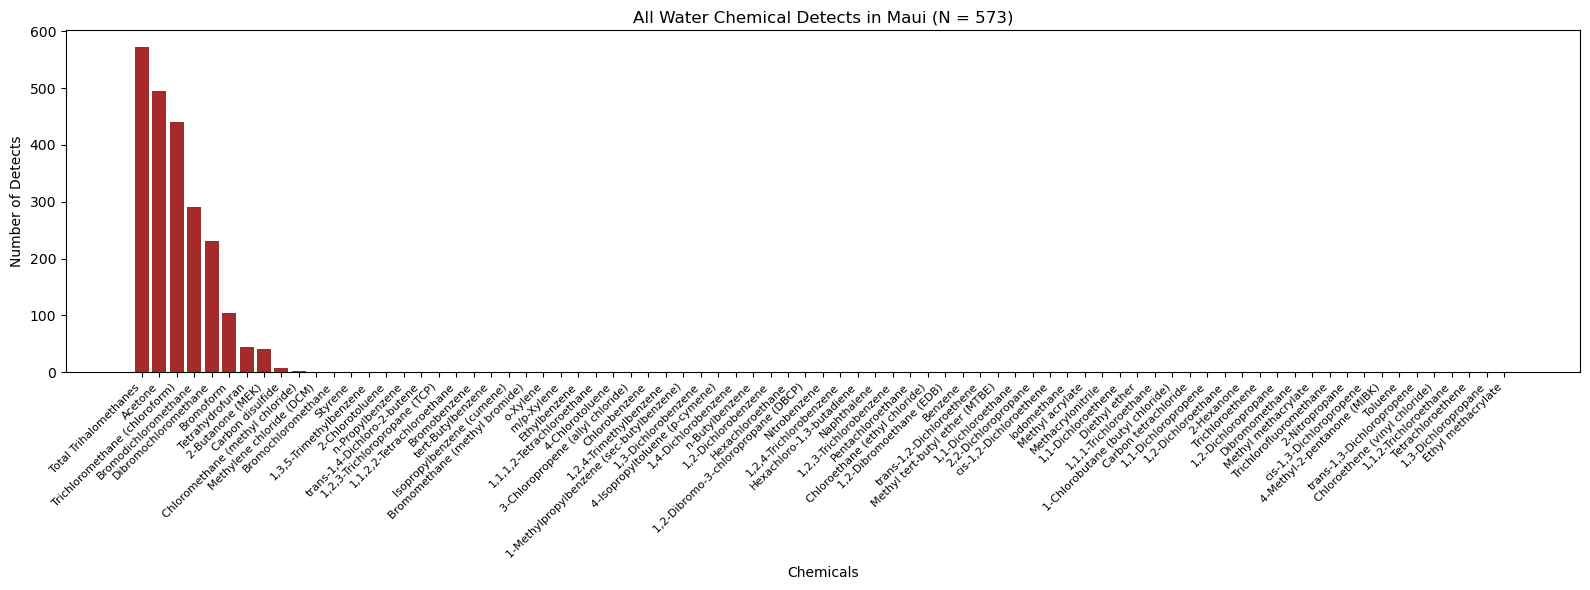

In [37]:
non_chemical_columns = ['Sample ID', 'SampleType', 'DateTime Taken', 'Public X', 'Public Y', 'Post Results']
chemical_columns = [col for col in merged_df.columns if col not in non_chemical_columns]
detect_counts = merged_df[chemical_columns].notna().sum()

# Total number of samples is the number of rows in merged_df
total_samples = len(merged_df)

# Create a DataFrame for plotting
detects_df = pd.DataFrame({
    'Chemical': detect_counts.index,
    'Number of Detects': detect_counts.values
}).sort_values(by='Number of Detects', ascending=False)
print(detects_df.head(14))

fig, ax = plt.subplots(figsize=(16, 6))  # Increase width to allow more spacing for labels

# Plot the bar chart
plt.bar('Chemical', 'Number of Detects', data=detects_df, color='brown')

# Rotate the x-axis labels and adjust their alignment
plt.xticks(rotation=45, ha='right', fontsize=8)

# Add more space between the x-ticks by reducing the number of ticks shown

# Title and labels
plt.xlabel("Chemicals")
plt.ylabel("Number of Detects")
plt.title(f'All Water Chemical Detects in Maui (N = {total_samples})')

# Adjust the layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

### Save files are .csv for further processing

In [38]:
merged_df.to_csv('All_Samples.csv')